### Introduction

I am testing the idea of using the juyter notebook as my script so the comments are verbose. Hopefully this helps synchronize the notebook content with the video. Comments on this approach are welcome.

More content like this can be found at [robotsquirrelproductions.com](https://robotsquirrelproductions.com/)

Today, I will take you through the steps to control and download data from your Rigol DS1054Z oscilloscope using Python in a Jupyter notebook. This tutorial uses the [DS1054Z library](https://ds1054z.readthedocs.io/en/stable/) written by Philipp Klaus. This library is required to replicate these examples in your environment.

I want to mention some sites I found helpful in learning about this. [Ken Shirrif's blog](http://www.righto.com/2013/07/rigol-oscilloscope-hacks-with-python.html) includes spectrographic analysis and how-to export to .wav file. Of course, the [programming manual](https://beyondmeasure.rigoltech.com/acton/attachment/1579/f-0386/1/-/-/-/-/DS1000Z_Programming%20Guide_EN.pdf) itself also proved helpful.

### Set up the notebook and import the libraries

I want to document the Python version used in this example. Import the `sys` library and print the version information.

In [1]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


Begin by importing libraries to connect to the oscilloscope and to display the data. The [Matplotlib package](https://matplotlib.org/) provides data plotting functionality.

In [2]:
from ds1054z import DS1054Z
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

The [IPython package](https://ipython.org/) provides libraries needed to display the oscilloscope bitmap images.

In [3]:
from IPython.display import Image, display

Finally, include the libraries from the [SciPy package](https://scipy.org/). These libraries enable single-sided spectral analysis.

In [4]:
from scipy.fft import rfft, rfftfreq

### Connect to oscilloscope

Next, I need to connect to the  oscilloscope to verify it responds to basic commands.

In [5]:
scope = DS1054Z('192.168.1.206')
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


The scope should respond with the make, model, and serial number. It looks like it has, so we have a good connection. 

Ensure the scope is in the run mode to collect some data.

In [6]:
scope.run()

### Download a waveform (source screen)

#### Configure the oscilloscope

I have channel 1 connected to a magnetic pickup. For details on which magnetic pickup I used and how I wired it to oscilloscope, check out my blog post on [selecting magnetic pickups](https://robotsquirrelproductions.com/selecting-a-magnetic-pickup/).

The pickup views a shaft rotating about 600 RPM. I would like to see about 5-6 revolutions on the screen. For this reason, I will set the horizontal time scaling to 50 ms/division. I will also set the probe ratio to unity and the vertical scale to 125 mV/division. These commands use the DS1054Z library, but VISA commands could also be used.

In [7]:
scope.set_probe_ratio(1, 1)
scope.set_channel_scale(1, 0.125)
scope.timebase_scale = 0.050

#### Configure the trigger

I want to set the trigger to capture a similar waveform each time I read data from the oscilloscope. Setting the trigger fixes the signal with respect to the grid. The magnetic pickup provides a signal that rises to approximately 200 mV, so I put the trigger level at 100 mV.

I switched to VISA commands instead of using the DS1054Z functions. The `write` function sends the VISA commands. 

In [8]:
d_trigger_level = 0.1
scope.write(':trigger:edge:source CHAN1')
scope.write(':trigger:edge:level ' + format(d_trigger_level))

#### Download Rigol screen bitmap

With the signals captured, I place the oscilloscope in **STOP** mode. This ensures the buffer contents do not change as I pull configuration information.

In [9]:
scope.stop()

Take a screenshot of the data from the scope. A bitmap showing the oscilloscope configuration can be a helpful reference to check some of the calculations below.

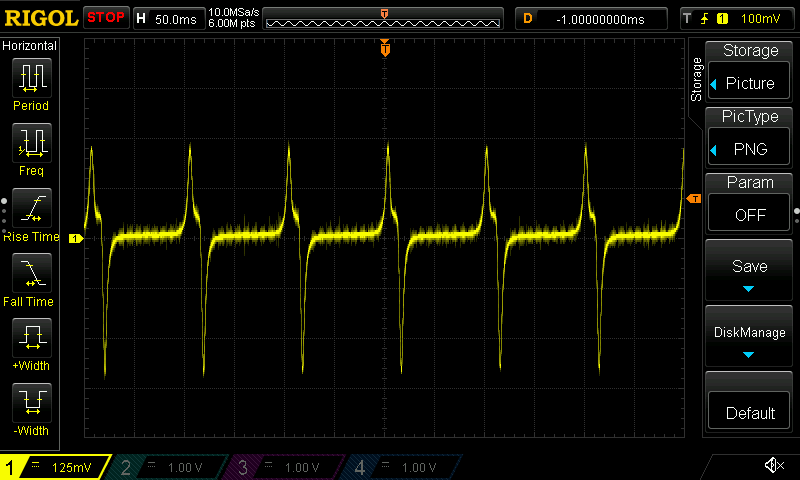

In [10]:
bmap_scope = scope.display_data
display(Image(bmap_scope, width=800))

The screen capture confirms the configuration parameters. For example, the top right shows the trigger configured for a rising edge with a threshold value of 100 mV. In the top left, beside the Rigol logo, the image shows the scope is in stop mode and that the horizontal ("H") axis has 50 ms/division. The bottom left corner indicates that channel 1 has been configured for 125 mV/division.

The screen also has information about the memory layout. The top middle of the screen shows a wavy line. Depending on the scope configuration part of the wavy line may be greyed out, reference the image below. The portion of the wavy line in the clear represents the screen buffer. The origin for the screen buffer begins at the left of this clear area. In contrast the RAW memory begins at the left of the wavy line. 

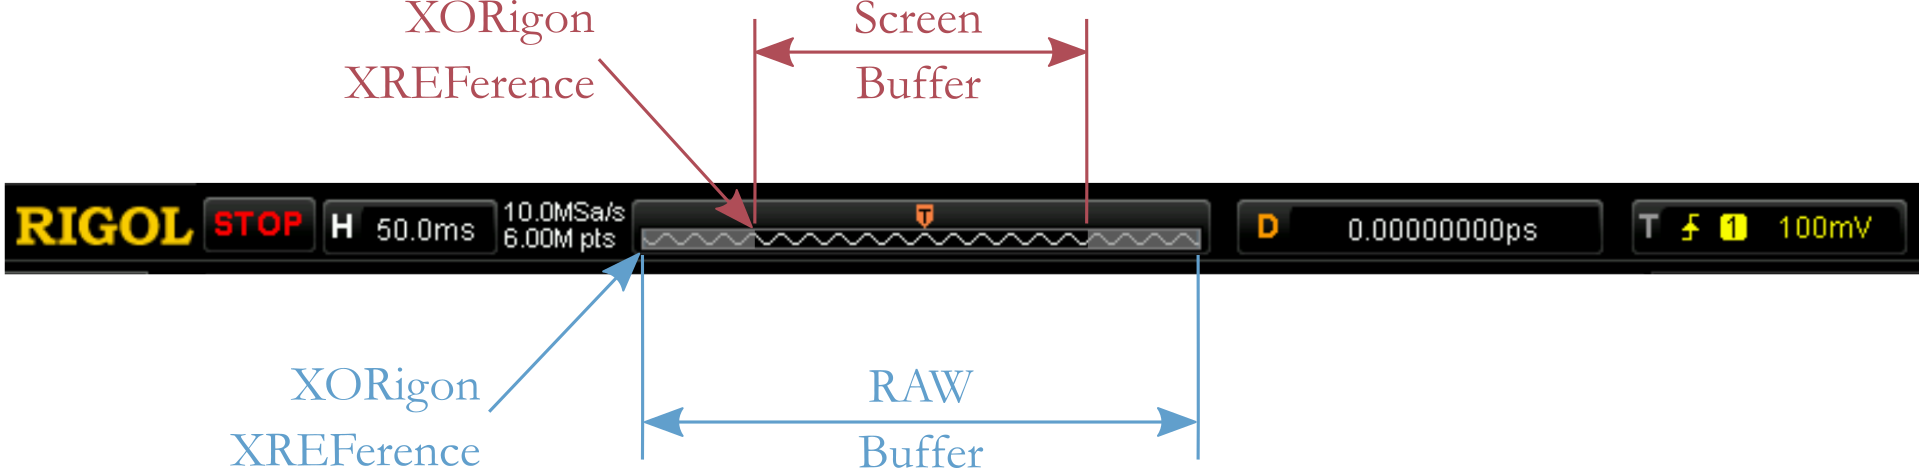

In [11]:
Image(filename="RigolBufferLayout.png", width=800)

#### Download oscilloscope configuration

Begin preparing for data collection. First,save off the vertical scale characteristics. Next, store the timescale value.

In [12]:
d_voltage_scale = scope.get_channel_scale(1)
print('Vertical scale: %0.3f volts' % d_voltage_scale)
d_timebase_scale_actual = float(scope.query(':TIMebase:SCAle?'))
print('Horizontal time scale: %0.3f seconds' % d_timebase_scale_actual)

Vertical scale: 0.125 volts
Horizontal time scale: 0.050 seconds


I like to store the instrument identification to describe the device that acquired the signal. I include this descriptive identifier on the plots along with the signal itself. This can be helpful if you later. For example, if you later find a problem instrument, this helps identify projects or work that might be impacted.

In [13]:
str_idn = scope.idn
print(str_idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


#### Download the signal and plot it

Next, I use the `get_waveform_samples` function to download the waveform. I set the mode to **NORM** to capture the screen buffer.

In [14]:
d_ch1 = scope.get_waveform_samples(1, mode='NORM')

The scope should always return 1200 samples. I use the `scope.memory_depth_curr_waveform` command to pull the number of samples.

In [15]:
i_ns = scope.memory_depth_curr_waveform
print('Number of samples: %0.f' % i_ns)

Number of samples: 1200


The scope has twelve horizontal divisions, so the total time for the sample is 50 ms * 12 = 600 ms. Knowing the number of samples and the total length of time, I estimate the sampling frequency as 1200/600 ms = 2000 hertz.

In [16]:
d_fs = i_ns/(12.0 * d_timebase_scale_actual)
print('Sampling frequency: %0.3f hertz' % d_fs)

Sampling frequency: 2000.000 hertz


Next, I create a time series vector for the independent axis in the plot.

In [17]:
np_d_time = np.linspace(0,(i_ns-1),i_ns)/d_fs

Restore the oscilloscope to **RUN** mode.

In [18]:
scope.run()

Calculation of the time series completes the plotting preparation. Next, I write up the lines needed to create the [timebase plot](https://robotsquirrelproductions.com/vibration-data-visualization/#timebase-plot). To zoom in and see more detail, change the x-axis limits to `plt.xlim([0, 0.1])` and comment out both `#plt.xticks(np.linspace(0, xmax, 13))` and `#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))` lines. With these changes, the plot will show the first 100 ms.

<function matplotlib.pyplot.show(close=None, block=None)>

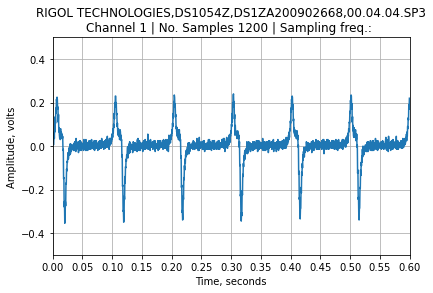

In [19]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.figure
plt.plot(np_d_time, d_ch1)
plt.grid()

plt.xlabel('Time, seconds')
xmax = 12.0*d_timebase_scale_actual
plt.xlim([0, xmax])
plt.xticks(np.linspace(0, xmax, 13))
ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.ylabel('Amplitude, volts')
plt.ylim([-4.0*d_voltage_scale, 4.0 *d_voltage_scale])
plt.title(str_idn + '\nChannel 1 | No. Samples %0.f | Sampling freq.: ' % i_ns)

figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('Timebase_Screen.pdf')

plt.show

One note of caution: I do not know if the oscilloscope anti-aliased the signal before downsampling for the screen. The programming manual does not provide much detail. It only says it samples at equal time intervals to rebuild the waveform. Not knowing more details, I believe the RAW waveform should be collected to avoid aliasing problems.

The plot matches the signal presented in the screen capture. Next, we will take a spectrum of this data to examine the frequency content.

#### Spectral analysis (source: screen)

A separate [video](https://youtu.be/8KWPlno6VP0) and [blog post](https://robotsquirrelproductions.com/spectral-analysis-in-python/) covers the basics of single-sided spectral analysis in Python. For this reason, I only present the code here. These commands calculate the single-sided spectrum and labels for the frequency axis.

In [20]:
cx_y = rfft(d_ch1)/float(i_ns/2.)
d_ws = rfftfreq(i_ns,1./d_fs)

Create the plot and display the single-sided spectrum. I used the plot function to create linear scales in the code below. In the video I also use a logarithmic vertical axis scale ("log scale"). Log scales show details that linear scales may miss. For example, to see the noise floor change the second line below to `plt.semilogy(d_ws, abs(cx_y))`. Also, change the fifth line to `plt.xlim([0, 1000])` so that the x-axis limits to 0 to 1000 hertz. The flat section of the spectrum from 200 to 1000 hertz shows the noise floor.

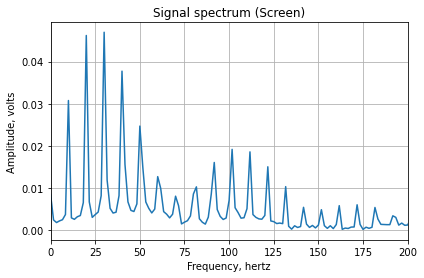

In [21]:
plt.figure()
plt.plot(d_ws, abs(cx_y))
plt.grid()
plt.xlabel('Frequency, hertz')
plt.xlim([0, 200])
plt.ylabel('Amplitude, volts')
plt.title('Signal spectrum (Screen)')

figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('Spectrum_Screen.pdf')

### Download a waveform (RAW)

The previous example downloaded the samples from the screen buffer. This example takes it further and downloads the data stored in memory. The overall workflow will be similar, but some details are different.

Begin by setting the scope mode to **STOP**.

In [22]:
scope.stop()

Next, get the information needed to make sense of the signals. I start with the vertical scale.

In [23]:
d_voltage_scale_raw = scope.get_channel_scale(1)
print('Vertical scale: %0.3f volts' % d_voltage_scale_raw)

Vertical scale: 0.125 volts


The sampling frequency can be downloaded directly from the oscilloscope for this example. The value returned by `:ACQuire:SRATe?` should match the value in the screenshot, highlighted by a red rectangle in the image below.

Sampling rate: 10.0 Msp/s 


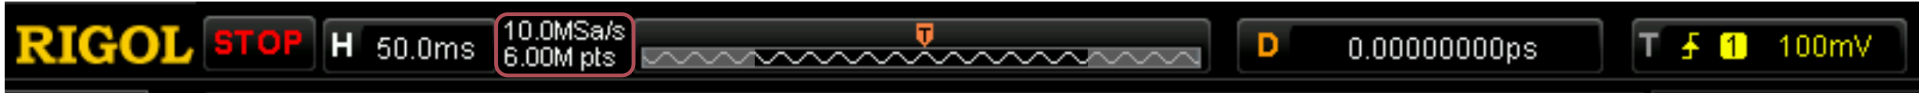

In [30]:
d_fs_raw = float(scope.query(":ACQuire:SRATe?"))
print("Sampling rate: %0.1f Msp/s " % (d_fs_raw/1e6))
Image(filename="RigolSampling.png", width=800)

The `memory_depth_internal_currently_shown` returns the number of samples in raw (or deep) memory. This describes the number of samples in the raw memory for the screen's current signal.

In [31]:
i_ns_raw = scope.memory_depth_internal_currently_shown
print('Number of samples: %0.f' % i_ns_raw)

Number of samples: 6000000


In keeping with good practices, I pull the instrument identification again

In [26]:
str_idn_raw = scope.idn
print(str_idn_raw)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


Next, I enter the Python command to download data from the oscilloscope. Downloading the signal takes a lot of time, on the order of 5-8 minutes for my arrangement. I have found that the cell must be run manually, using `Ctrl-Enter`. Alternatively, the `time.sleep()` function could be used to pause the notebook execution and allow the upload to complete.

In [27]:
d_ch1_raw = scope.get_waveform_samples(1, mode='RAW')

Lastly, I set up the time series for this raw waveform.

In [32]:
np_d_time_raw = np.linspace(0,(i_ns_raw-1), i_ns_raw)/d_fs_raw

Place the oscilloscope in **RUN** mode.

In [33]:
scope.run()

Now I can plot this channel signal data. To zoom in and see more detail, change the x-axis limits to `plt.xlim([0, 0.1])` and comment out both `#plt.xticks(np.linspace(0, xmax, 13))` and `#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))` lines. With these changes, the plot will show the first 100 ms.

<function matplotlib.pyplot.show(close=None, block=None)>

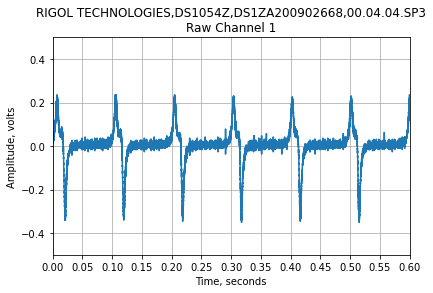

In [34]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.figure
plt.plot(np_d_time_raw, d_ch1_raw)
plt.grid()

plt.xlabel('Time, seconds')
xmax = float(i_ns_raw)/d_fs_raw
plt.xlim([0, xmax])
plt.xticks(np.linspace(0, xmax, 13))
ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.2f'))

plt.ylabel('Amplitude, volts')
plt.ylim([-4.0*d_voltage_scale_raw, 4.0 *d_voltage_scale_raw])
plt.title(str_idn_raw + '\n' + 'Raw Channel 1')

figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('Timebase_Raw.pdf')

plt.show

#### Spectral analysis (source: RAW)

These commands calculate the single-sided spectrum and labels for the frequency axis for the raw data.

In [85]:
cx_y_raw = rfft(d_ch1_raw)/float(i_ns_raw/2.)
d_ws_raw = rfftfreq(i_ns_raw,1./d_fs_raw)

Create the plot and display the single-sided spectrum. To replicate the results in the video, floor change the second line below to `plt.semilogy(d_ws, abs(cx_y))`. Also, change the fifth line to `plt.xlim([0, 1000])` so that the x-axis limits to 0 to 1000 hertz. The flat section of the spectrum from 200 to 1000 hertz shows the noise floor.

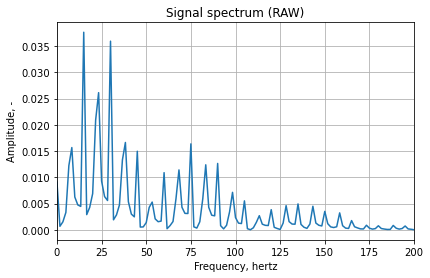

In [91]:
plt.figure()
plt.plot(d_ws_raw, abs(cx_y_raw))
plt.grid()
plt.xlabel('Frequency, hertz')
plt.xlim([0, 200])
plt.ylabel('Amplitude, -')
plt.title('Signal spectrum (RAW)')

figure = plt.gcf()
figure.set_size_inches(4*1.6, 4)
plt.savefig('Spectrum_Raw.pdf')

### Conclusion

In this notebook, I used Python to pull data from a Rigol DS1054Z and plot both timebase and spectrum domain data. I hope you find the notes helpful.